In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from types import SimpleNamespace
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout, ConvResNet_batchnormMLP
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False


In [3]:
def predictions_to_image(predictions, input_image, config, patch_size):

    y_hat = torch.cat([x[0] for x in predictions]).squeeze()
    y = torch.cat([x[1] for x in predictions]).squeeze()
    lat = torch.cat([x[2][:, 1] for x in predictions])
    lon = torch.cat([x[2][:, 2] for x in predictions])

    img_dim = (len(input_image.lon) - config.patch_size['x'] +1,
               len(input_image.lat) - config.patch_size['y'] +1,)
    
    y_hat = y_hat.reshape(img_dim)
    y = y.reshape(img_dim)
    lat = lat.reshape(img_dim)
    lon = lon.reshape(img_dim)

    y_hat = config.target_transform.inverse(y_hat, ["SIS"])
    y = config.target_transform.inverse(y, ["SIS"])
    lat = config.transform.inverse(lat, ["lat"])
    lon = config.transform.inverse(lon, ["lon"])

    output_image = xarray.DataArray(
        data=y_hat.T,
        # dims=('x','y'),
        coords={"lat": (('lat'), lat[0, :]),
                "lon": (('lon'), lon[:, 0]),},
        attrs=input_image.SIS.attrs,
    )

    output_image.lat.attrs = input_image.lat.attrs
    output_image.lon.attrs = input_image.lon.attrs
    return output_image, y, y_hat


def image_1d_to_2d(arr, dim, patch_size):
    return arr.reshape(
        dim[0] - patch_size["y"] + 1,
        dim[1] - patch_size["x"] + 1,
    )

def plot_comparison_image(output_image, ground_truth_image, extent=None, savefig = True):
    nm = ground_truth_image.name
    time = ground_truth_image.time.dt.strftime('%Y%m%d_%H%M').item()
    time_pretty = ground_truth_image.time.dt.strftime('%Y-%m-%d %H:%M').item()
    proj = ccrs.PlateCarree()
    # fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,6), subplot_kw={"projection": proj})
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(
        2,
        4,
        width_ratios=(3, 3, 3, .2),
        height_ratios=(3,.125),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.1,
    )
    ax1 = fig.add_subplot(gs[0, 0], projection=proj)
    ax2 = fig.add_subplot(gs[0, 1], projection=proj, sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2], projection=proj, sharex=ax1, sharey=ax1)
    axc1 = fig.add_subplot(gs[1, :2], autoscale_on=False)
    axc2 = fig.add_subplot(gs[:, 3])
    
    ax_text = fig.add_subplot(gs[1,2])
    ax_text.axis('off')
    ax_text.annotate(time_pretty, 
                xycoords='axes fraction',
                xy=[.3, .5])


    
    output_image.plot.imshow(x='lon', y='lat', 
                             vmin=0, vmax=1100, 
                             ax=ax1, transform=proj, add_colorbar=False)
    ground_truth_image.plot.imshow(x='lon', y='lat', 
                                   vmin=0, vmax=1100, ax=ax2, 
                                   transform=proj, cbar_ax=axc1,
                                  cbar_kwargs={'orientation':'horizontal', 'shrink':0.6, 'aspect':40,'label':'SIS [W/m2]'})
    
    error = output_image - ground_truth_image.reindex_like(output_image, method="nearest")
    error.plot.imshow(ax=ax3, transform=proj, cbar_ax=axc2)
    ax1.set_title("DL")
    ax2.set_title("SARAH3")
    ax3.set_title("y_pred - y")
    
    gls = {}
    for i, ax in enumerate([ax1,ax2,ax3]):
        ax.coastlines()
        gl = ax.gridlines(draw_labels=True, linewidth=.3)
        gl.top_labels = False
        gl.right_labels = False
        if i>0:
            gl.left_labels = False
        

    
    if extent is not None:
        ax1.set_xlim([extent[0], extent[2]])
        ax1.set_ylim([extent[1], extent[3]])
    
    if savefig:
        
        if extent is not None:
            extent_str = '_'.join([str(x) for x in extent])
            fig.savefig(inference_fn  + f'{nm}_comparison_{time}_{extent_str}.png')
        else:
            pass
            fig.savefig(inference_fn + f'{nm}_comparison_{time}.png')

# Config

In [4]:
## Set Up Model

# ckpt_fn = "/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/vh232f2j/checkpoints/epoch=11-step=11928.ckpt"
ckpt_fn = "/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/tfu3tyoy/checkpoints/epoch=2-step=2982.ckpt"

inference_fn = ckpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS", "SID", "KI"],
    "x_features": ["dayofyear", "lat", "lon", "SZA", "AZI"],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
}
config = SimpleNamespace(**config)



# Trainer and Model

In [5]:
# estimator = LitEstimator()
trainer = Trainer(
    # profiler="simple",
    # num_sanity_val_steps=2,
    accelerator="gpu",
    devices=-1,
    precision="32",
)

model = ConvResNet_batchnormMLP(
    num_attr=len(config.x_features),
    input_channels=len(config.x_vars),
    output_channels=len(config.y_vars),
)

estimator = LitEstimatorPoint.load_from_checkpoint(
    ckpt_fn,
    learning_rate=0.001,
    model=model,
    config=config,
)

/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning2/lib/python3.9/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Station dataset

In [6]:
stations = ["CAB", "CAR", "CEN", "MIL", "NOR", "PAL", "PAY", "TAB", "TOR", "VIS"]

test_datasets = [
    GroundstationDataset(
        nm,
        config.y_vars,
        config.x_vars,
        config.x_features,
        patch_size=15,
        time_window=12,
        transform=config.transform,
        target_transform=config.target_transform,
    )
    for nm in stations]

/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packag

In [7]:
ds = test_datasets[0]
ds.

['SIS', 'SID', 'KI']

In [ ]:
solarpos = xarray.open_zarr("/scratch/snx3000/kschuurm/ZARR/SOLARPOS.zarr").drop_duplicates(dim="time")

AZI = solarpos.sel(lat=51.97, lon=4.927, method='nearest').sel(time=time).AZI.load()
AZI_station = ds.rolling_station.AZI.load()

In [ ]:
plt.scatter(AZI, AZI_station, s=0.1)
plt.xlabel('AZI calculated')
plt.ylabel('AZI from station dataset')

In [ ]:
SZA = solarpos.sel(lat=51.97, lon=4.927, method='nearest').sel(time=time).SZA.load()
SZA_station = ds.rolling_station.SZA.load()

plt.scatter(SZA, SZA_station, s=0.1)
plt.xlabel('AZI calculated')
plt.ylabel('AZI from station dataset')

In [8]:
predictions_stations = [trainer.predict(estimator, DataLoader(ds, 400000, shuffle=False)) for ds in test_datasets]

predictions_stations = { nm: {'y_hat': torch.cat([p[0] for p in pred]),
                              'y': torch.cat([p[1] for p in pred]),
                              'x': torch.cat([p[2] for p in pred]) } for nm, pred in zip(stations, predictions_stations)}

/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning2/lib/python3.9/s ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

CAB_SIS: 	 mean err: -7.0	 std err: 91.0 	 median err: -6.0 	 R2score: 0.627 	 RMSE: 90.652
CAB_SID: 	 mean err: -9.0	 std err: 181.0 	 median err: -37.0 	 R2score: 0.627 	 RMSE: 180.524
CAB_KI: 	 mean err: 0.0	 std err: 0.0 	 median err: 0.0 	 R2score: 0.627 	 RMSE: 0.219
CAR_SIS: 	 mean err: 5.0	 std err: 81.0 	 median err: 3.0 	 R2score: 0.479 	 RMSE: 80.721
CAR_SID: 	 mean err: 158.0	 std err: 292.0 	 median err: 121.0 	 R2score: 0.479 	 RMSE: 291.964
CAR_KI: 	 mean err: 0.0	 std err: 0.0 	 median err: 0.0 	 R2score: 0.479 	 RMSE: 0.207
CEN_SIS: 	 mean err: -9.0	 std err: 114.0 	 median err: -1.0 	 R2score: 0.495 	 RMSE: 114.174
CEN_SID: 	 mean err: 84.0	 std err: 263.0 	 median err: 26.0 	 R2score: 0.495 	 RMSE: 262.894
CEN_KI: 	 mean err: 0.0	 std err: 0.0 	 median err: 0.0 	 R2score: 0.495 	 RMSE: 0.237
MIL_SIS: 	 mean err: 6.0	 std err: 85.0 	 median err: 4.0 	 R2score: 0.607 	 RMSE: 84.83
MIL_SID: 	 mean err: 87.0	 std err: 222.0 	 median err: 39.0 	 R2score: 0.607 	 RMSE: 222

/scratch/snx3000/kschuurm/irradiance_estimation/utils/plotting.py:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))


TAB_SIS: 	 mean err: -8.0	 std err: 103.0 	 median err: -2.0 	 R2score: 0.478 	 RMSE: 103.209
TAB_SID: 	 mean err: 188.0	 std err: 315.0 	 median err: 137.0 	 R2score: 0.478 	 RMSE: 314.78
TAB_KI: 	 mean err: -0.0	 std err: 0.0 	 median err: -0.0 	 R2score: 0.478 	 RMSE: 0.221
TOR_SIS: 	 mean err: -17.0	 std err: 93.0 	 median err: -18.0 	 R2score: 0.581 	 RMSE: 92.961
TOR_SID: 	 mean err: -0.0	 std err: 178.0 	 median err: -36.0 	 R2score: 0.581 	 RMSE: 178.035
TOR_KI: 	 mean err: 0.0	 std err: 0.0 	 median err: 0.0 	 R2score: 0.581 	 RMSE: 0.259
VIS_SIS: 	 mean err: -20.0	 std err: 150.0 	 median err: -16.0 	 R2score: 0.466 	 RMSE: 149.783
VIS_SID: 	 mean err: 50.0	 std err: 236.0 	 median err: 9.0 	 R2score: 0.466 	 RMSE: 235.541
VIS_KI: 	 mean err: -0.0	 std err: 9.0 	 median err: -0.0 	 R2score: 0.466 	 RMSE: 8.702


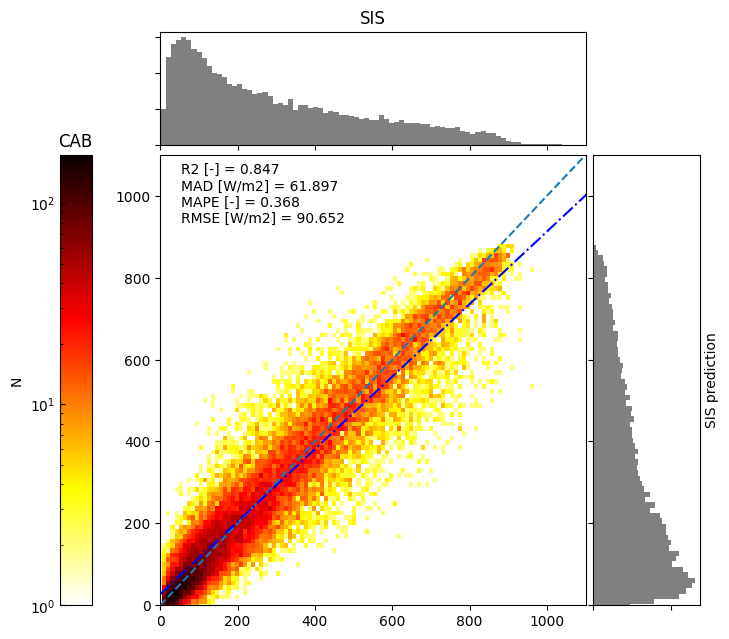

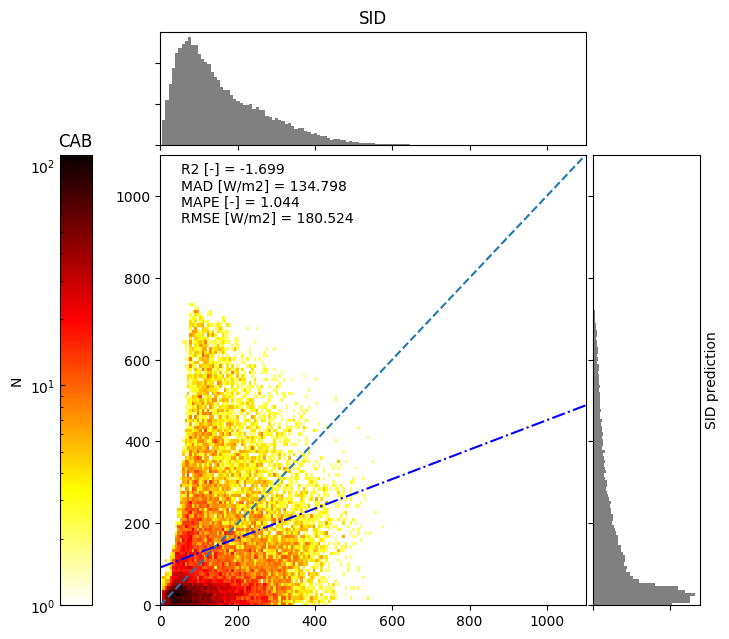

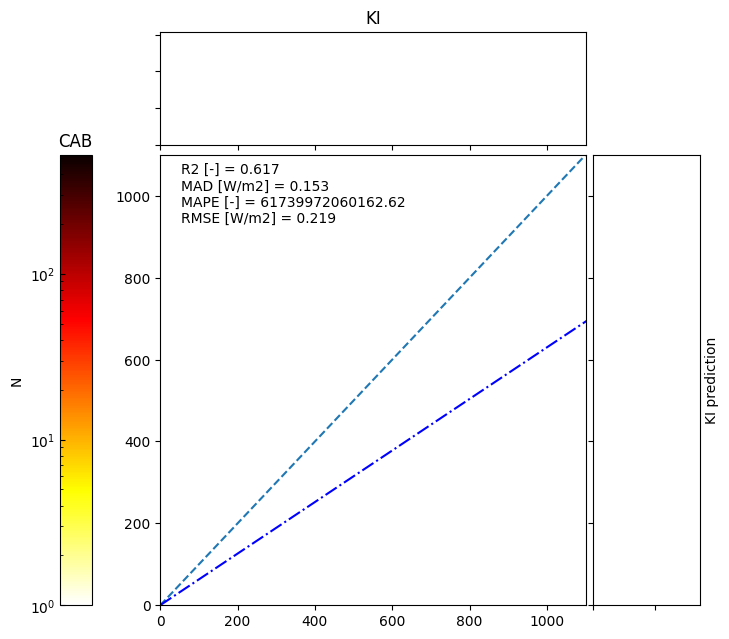

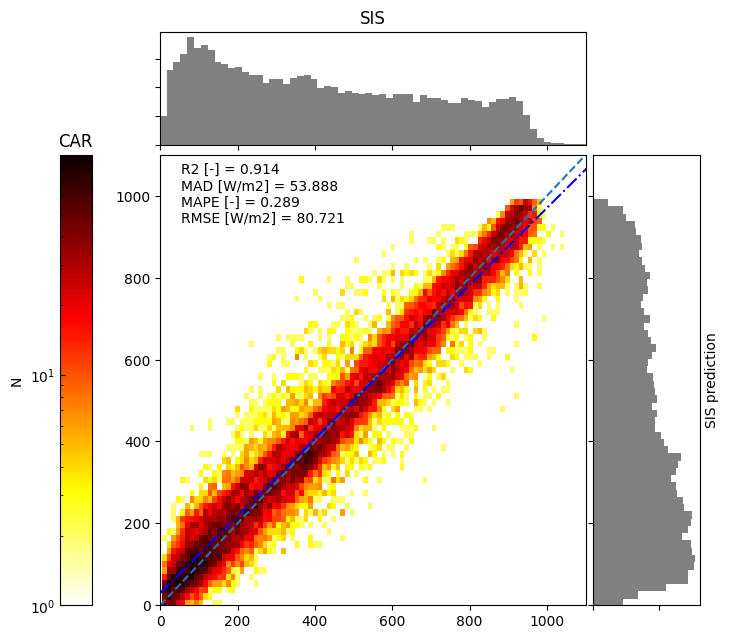

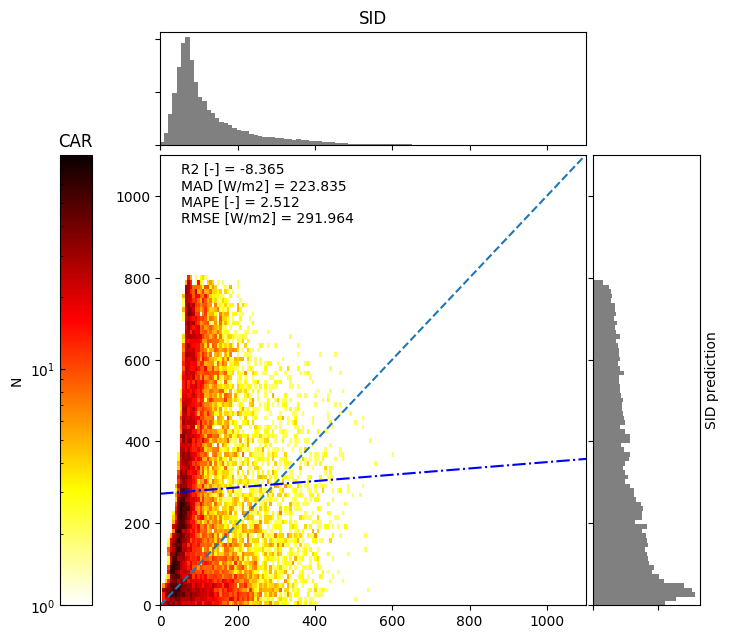

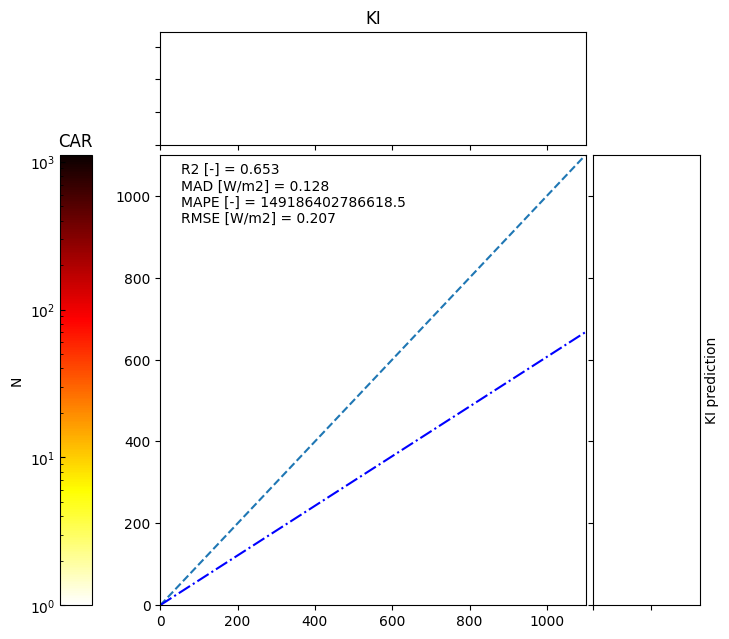

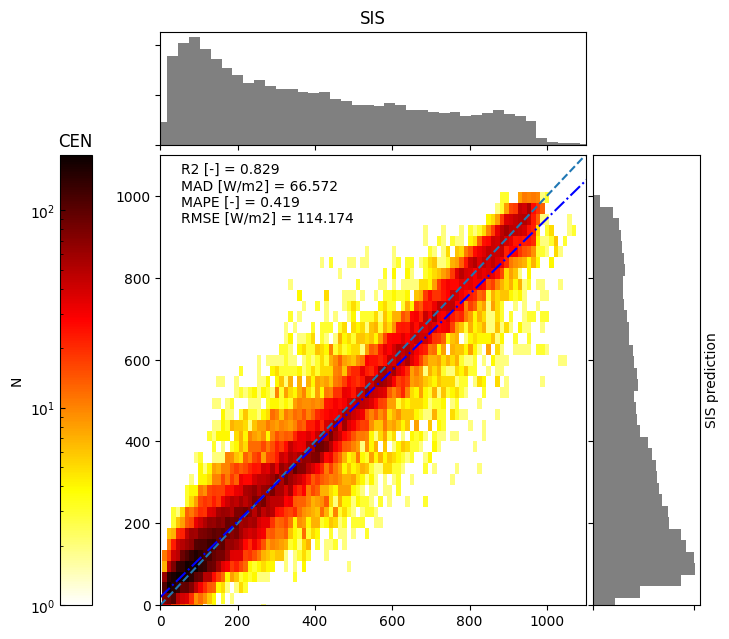

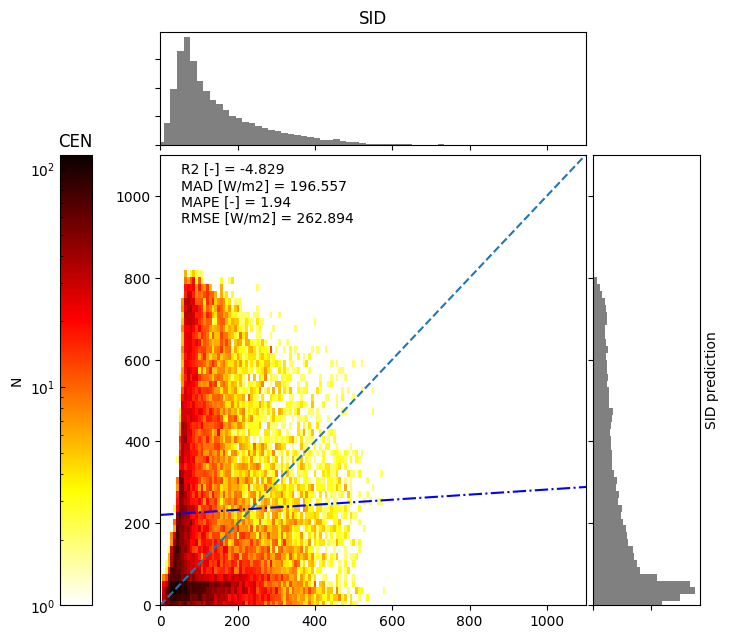

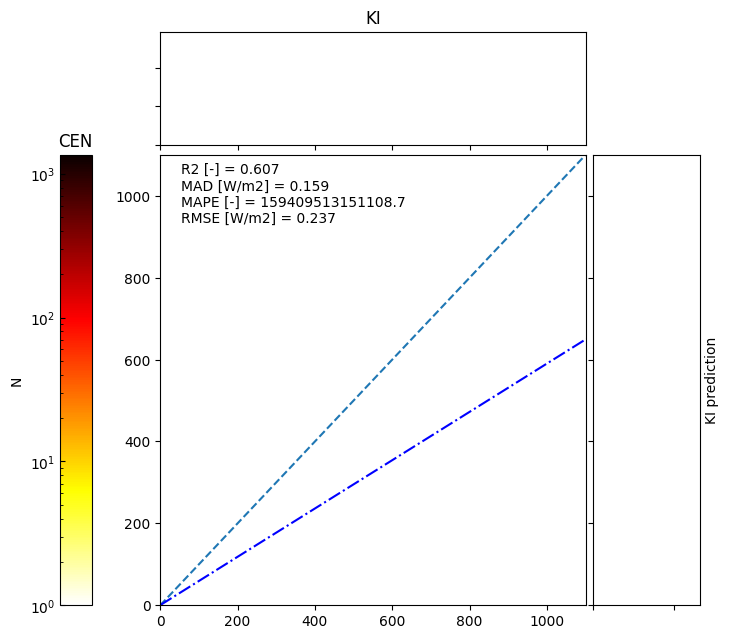

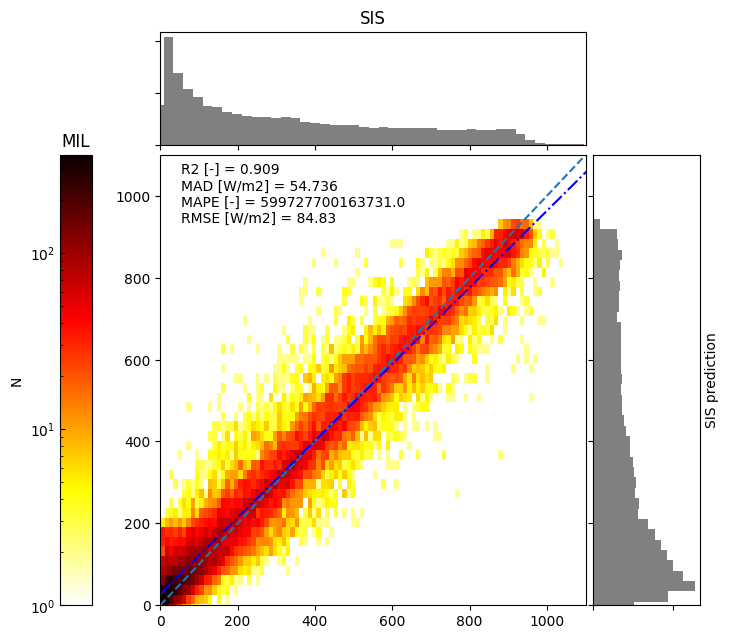

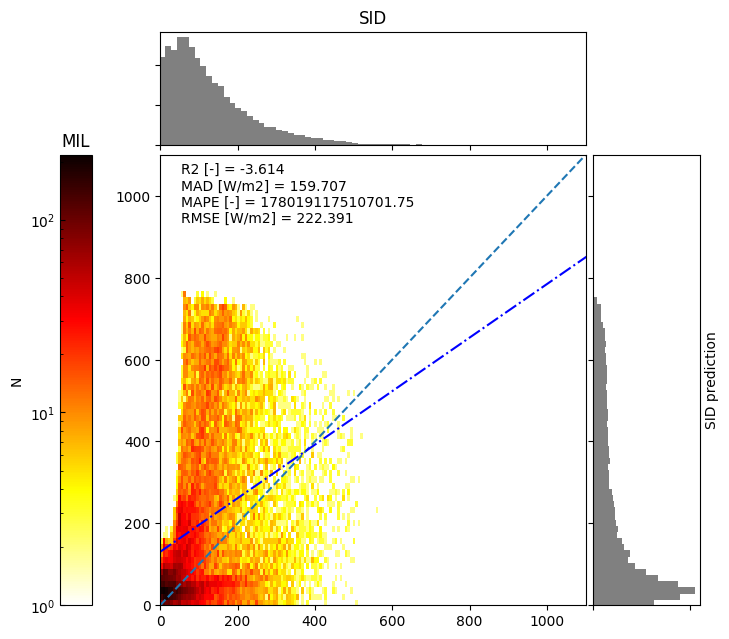

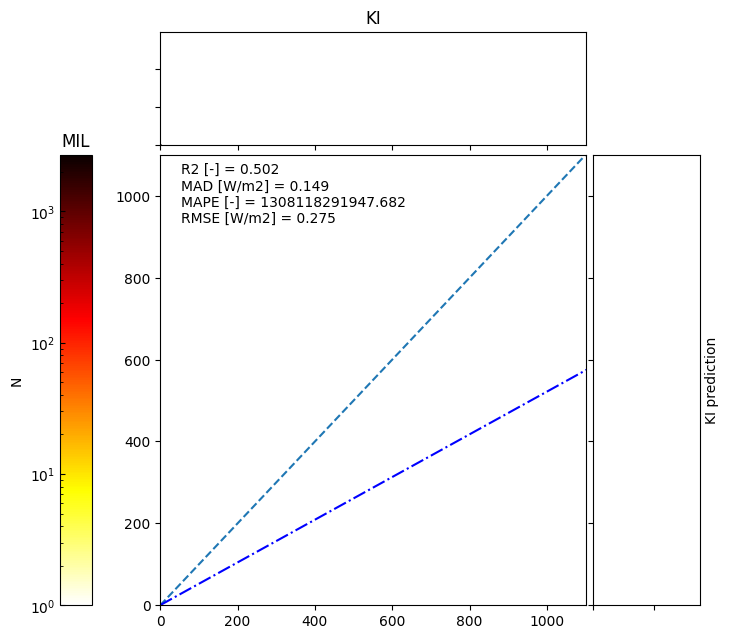

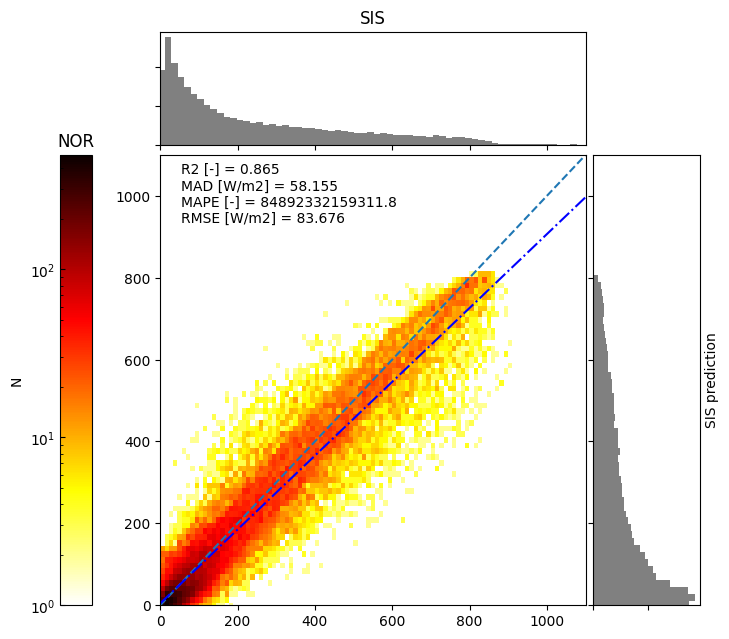

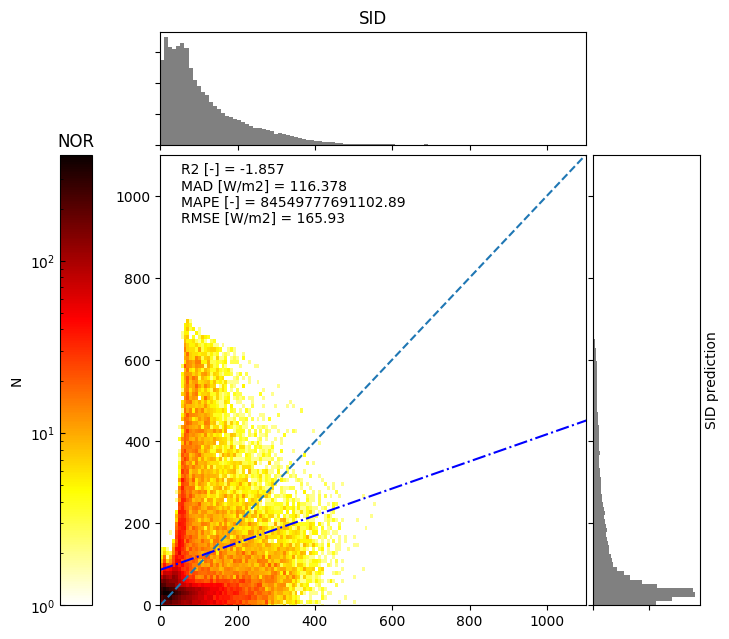

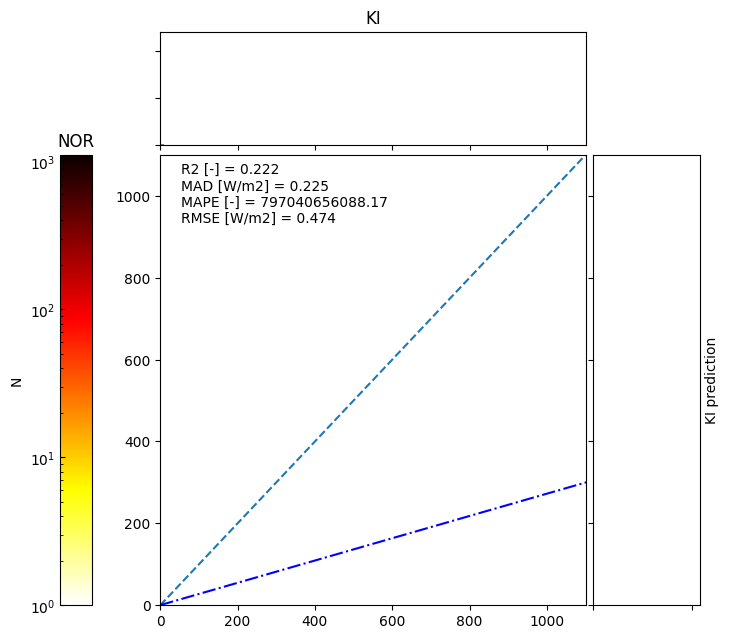

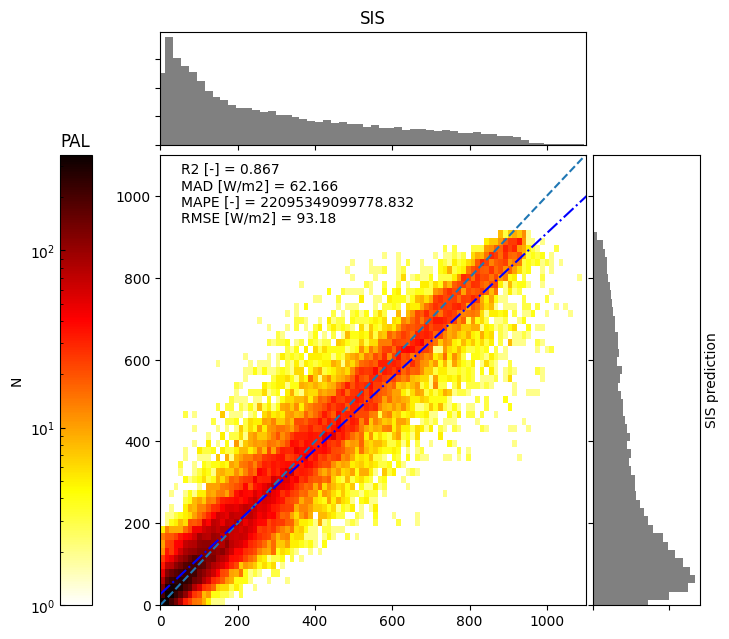

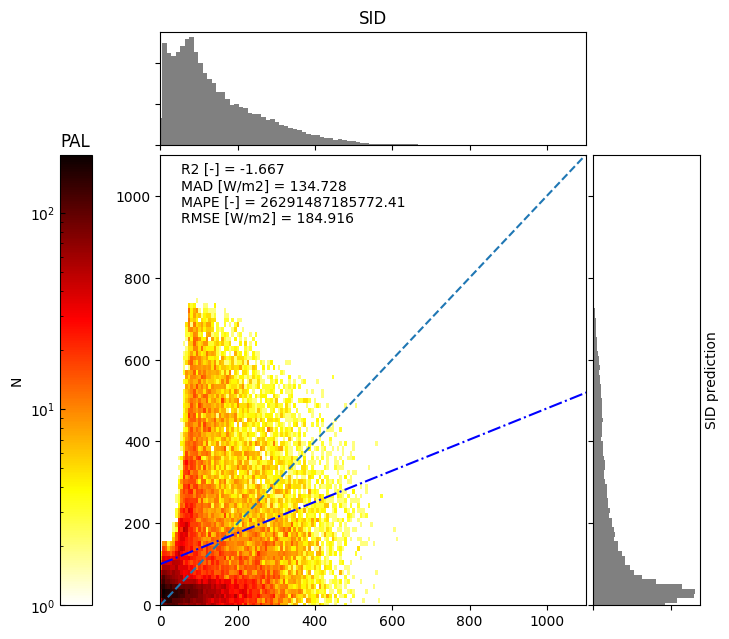

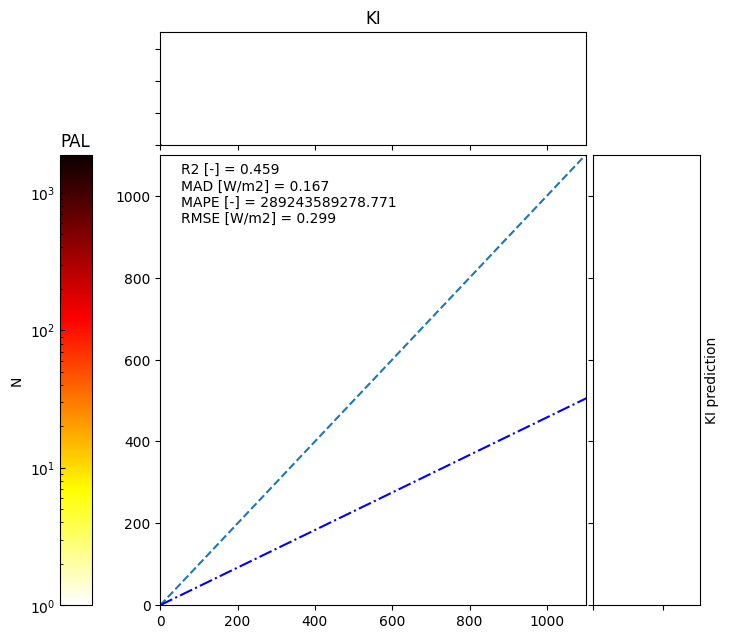

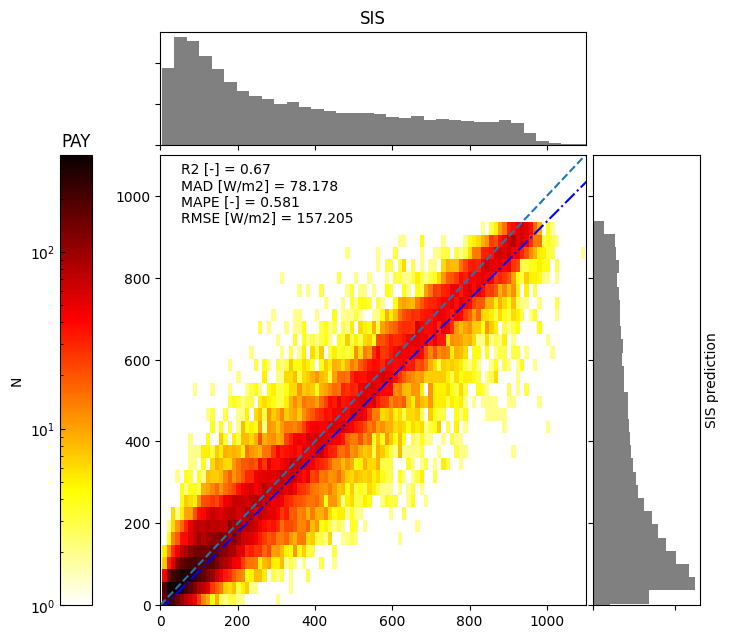

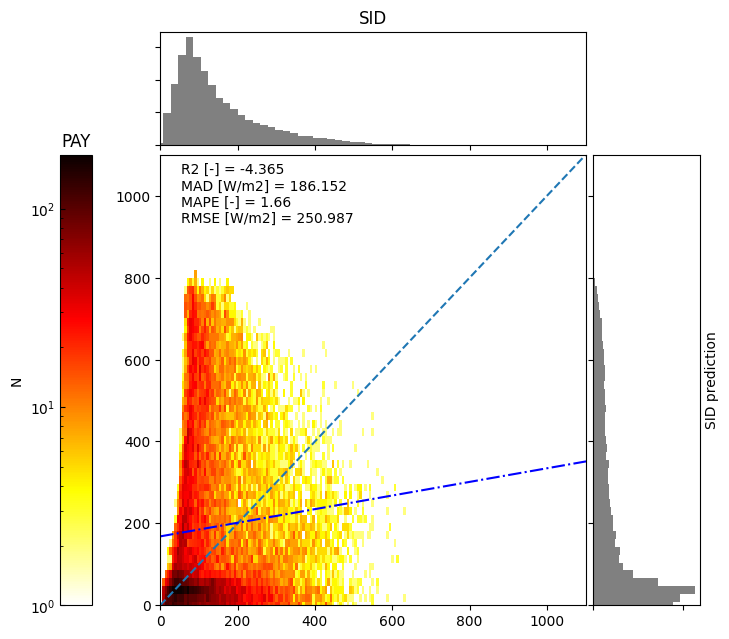

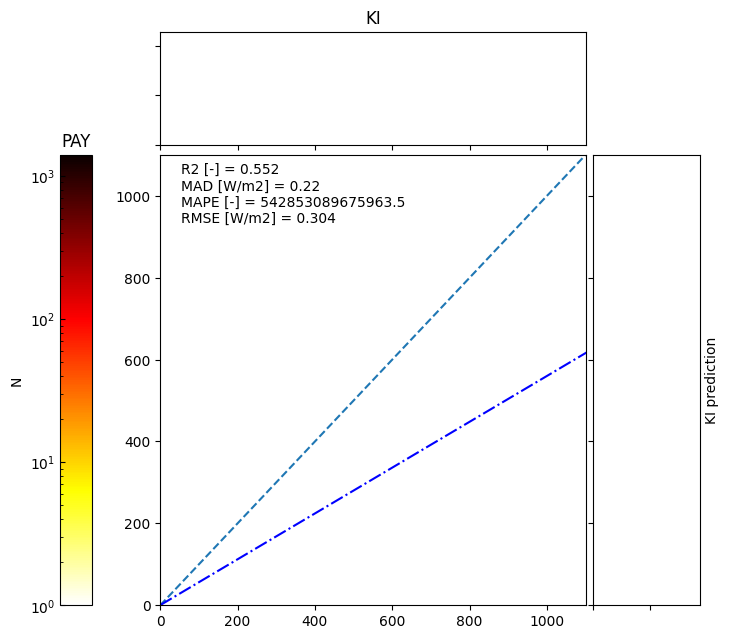

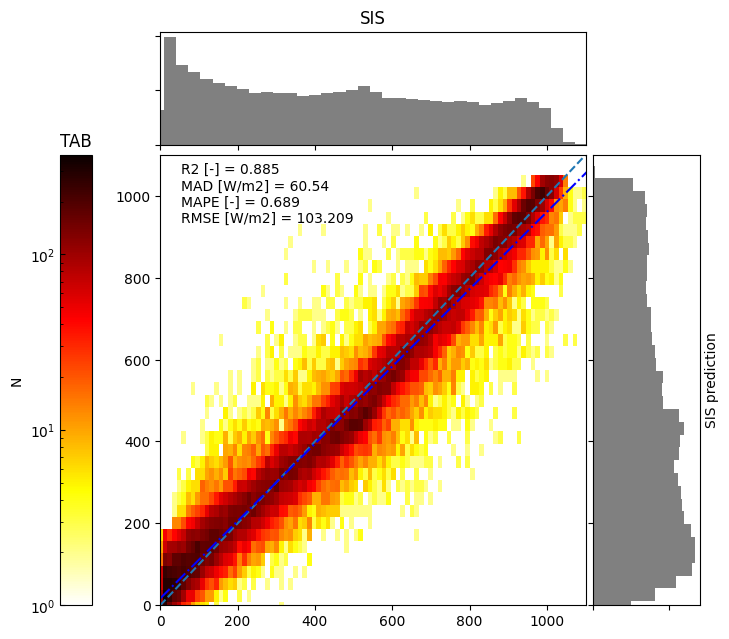

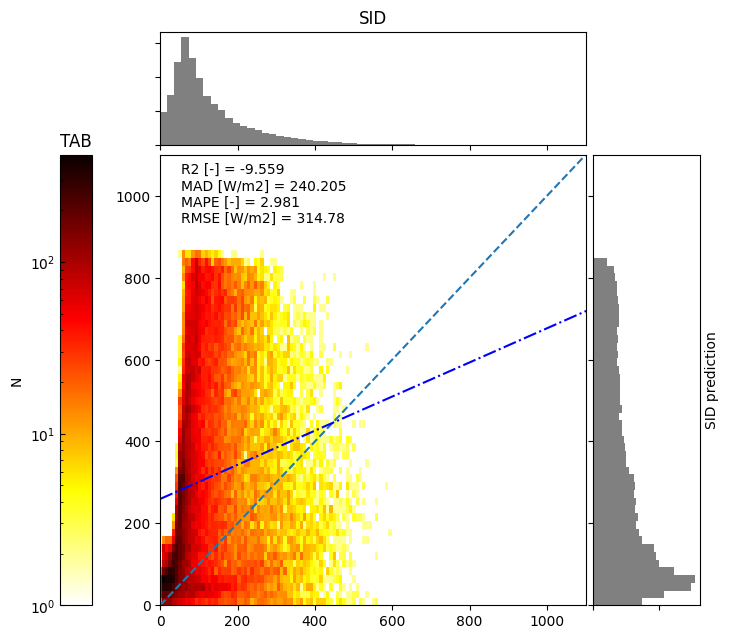

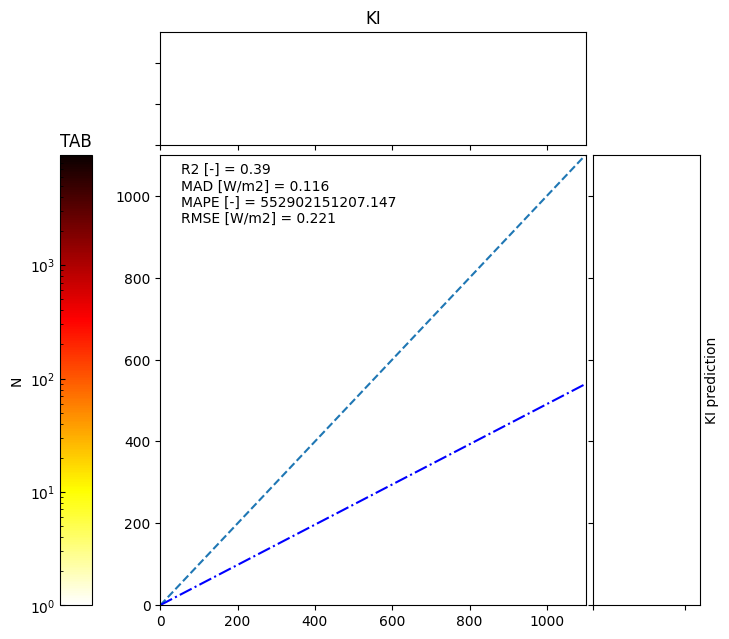

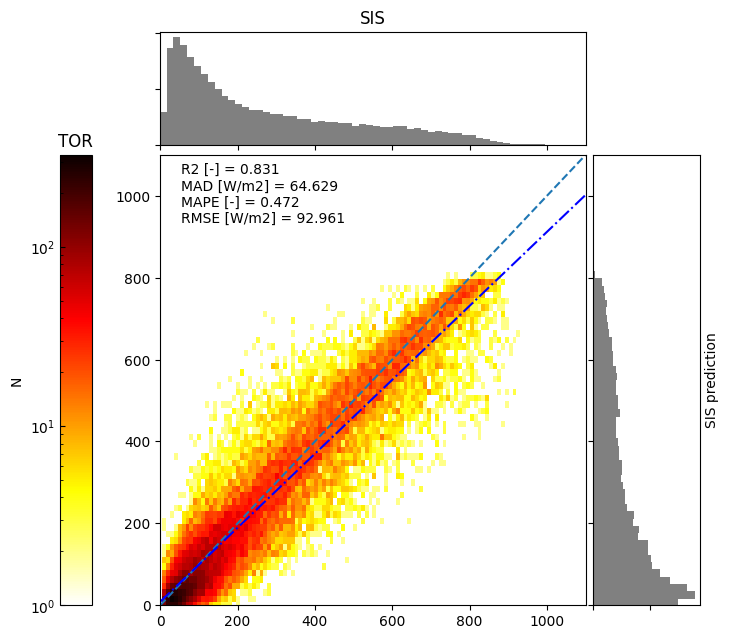

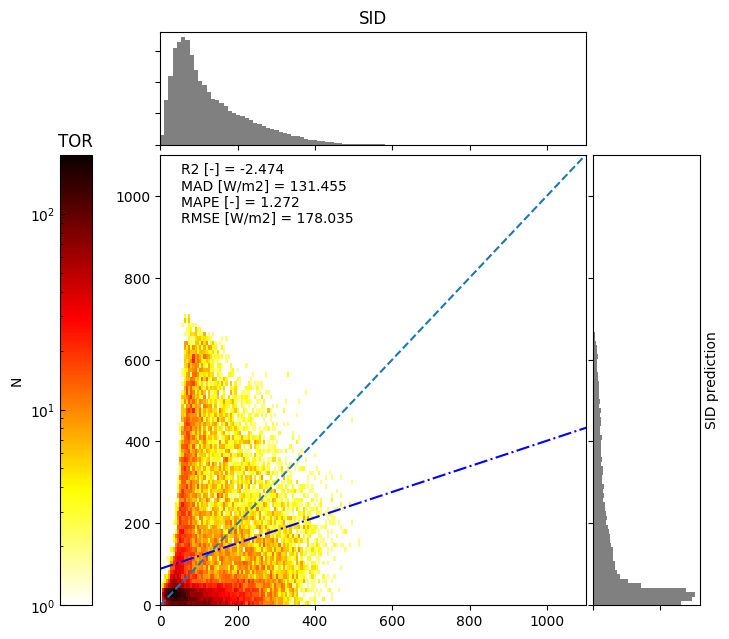

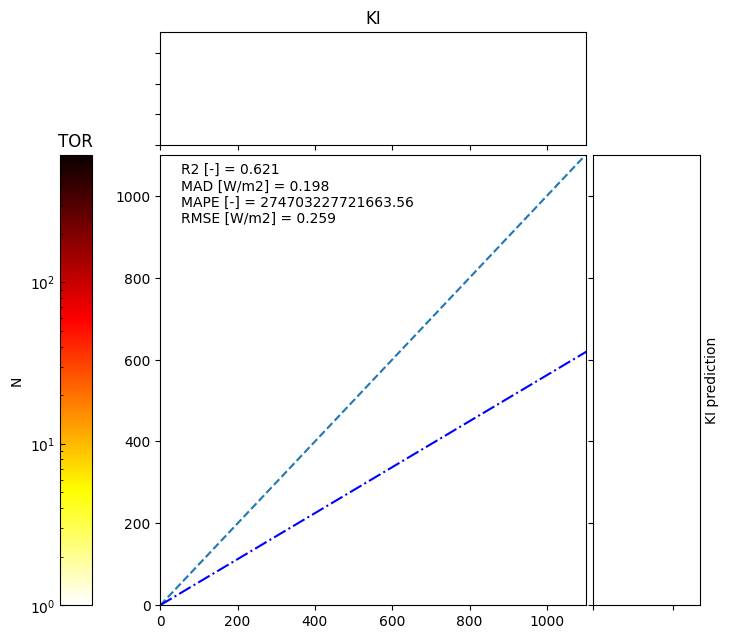

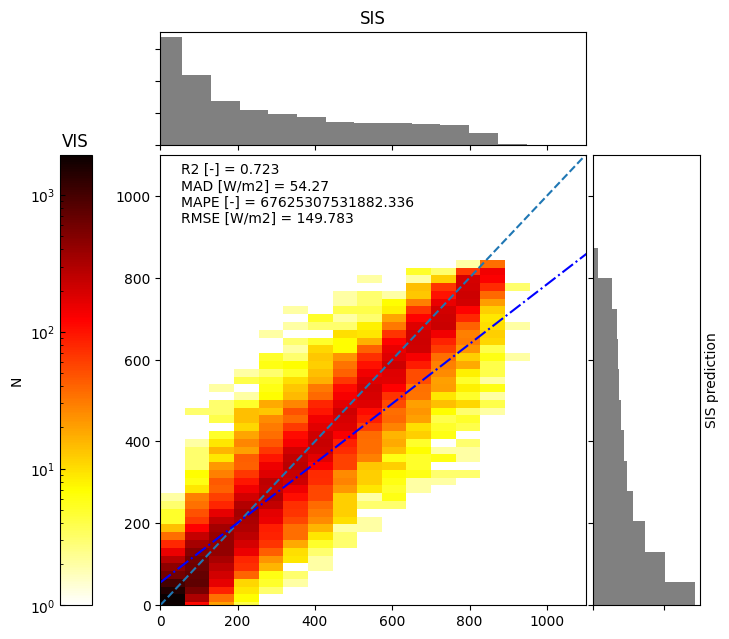

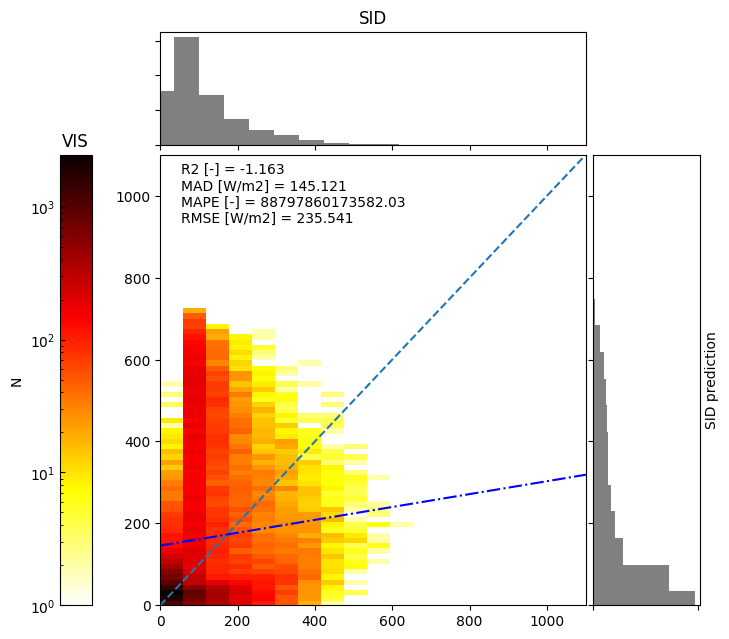

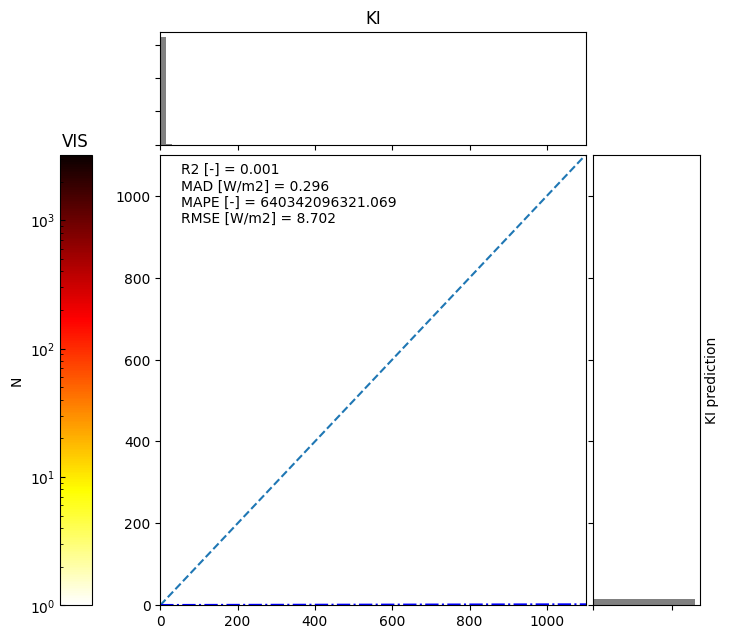

In [24]:
from torchmetrics import R2Score

r2score = R2Score()

def statistics_stations(predictions_stations, save = True):
    for key, val in predictions_stations.items():
        y_hat = config.transform.inverse(val['y_hat'].cpu().double(), config.y_vars)
        y = config.transform.inverse(val['y'].cpu().double(), config.y_vars)
        nans = y.mean(dim=1).isnan()
        y_hat = y_hat[~nans,:]
        y = y[~nans,:]
        error = y_hat - y
        for i, y_var in enumerate(config.y_vars):
            e = error[:,i]
            
            y_hat_i = y_hat[:,i]
            y_i = y[:,i]
            # error = config.transform.inverse(error.squeeze().cpu(), ["SIS"])
            mean = torch.nanmean(e).item()
            std = torch.sqrt(torch.nanmean(e**2)).item()
            median = torch.nanmedian(e).item()
            rmse = torch.sqrt(torch.nanmean(e**2)).item()
            R2 = r2score(y_hat.flatten(), y.flatten()).item()
            print(f"{key}_{y_var}: \t mean err: {np.round(mean)}\t std err: {np.round(std)} \t median err: {np.round(median)} \t R2score: {round(R2, 3)} \t RMSE: {round(rmse,3)}")
            fig = prediction_error_plot(y_i, y_hat_i, title=key, output_var=y_var)
            fig.savefig(inference_fn + f'prediction_error_plot_{y_var}_{key}.png')
        
        
statistics_stations(predictions_stations)

# Full image comparison

In [13]:
imageDataset = ImageDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    random_sample=None,
    batch_in_time=None,
    dtype=torch.float32,
)

dts = imageDataset.images

In [22]:
a = pd.DatetimeIndex([dt[0] for dt in dts])
a = a[a.year == 2016]

In [ ]:
from dataset.dataset import valid_test_split, pickle_write, pickle_read

_, subset = valid_test_split(a)
subsubset = np.random.choice(subset, 200, replace=False)
subsubset

In [ ]:
from dataset.dataset import valid_test_split, pickle_write, pickle_read
for dt in tqdm(subsubset[:]):
    try:
        dataset = imageDataset.load_singleImageDataset_generator(dt=[dt]).result()
        

        time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
        fn = inference_fn + f'predictions/predictions_{time_str}.pkl'
        os.makedirs(os.path.dirname(fn), exist_ok=True)
        if not os.path.exists(fn):
            dataloader = DataLoader(dataset, batch_size=1000, num_workers=3)
            predictions = trainer.predict(estimator, dataloader)
            pickle_write(predictions, fn)
        else:
            predictions = pickle_read(fn)

        output_image, y, y_hat = predictions_to_image(
            predictions, dataset.sarah, config, config.patch_size
        )
        plot_comparison_image(output_image, dataset.sarah.isel(time=0).SIS)#, extent=[5, 40, 15,50])

        fig = prediction_error_plot(y.flatten(), y_hat.flatten())
        time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
        fig.savefig(inference_fn + f'prediction_error_plot_{time_str}.png')
    except Exception as e:
        print(dt)
        print(e)
        

In [13]:
dataset = imageDataset.load_singleImageDataset_generator(dt=dts[4200]).result()

In [14]:
dataloader = DataLoader(dataset, batch_size=1000, num_workers=3)
predictions = trainer.predict(estimator, dataloader)

/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning2/lib/python3.9/s ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
output_image, y, y_hat = predictions_to_image(
    predictions, dataset.sarah, config, config.patch_size
)

{'R2 [-]': 0.6414765370077473, 'MAD [W/m2]': 37.51197, 'MAPE [-]': 3.0853662e+16}


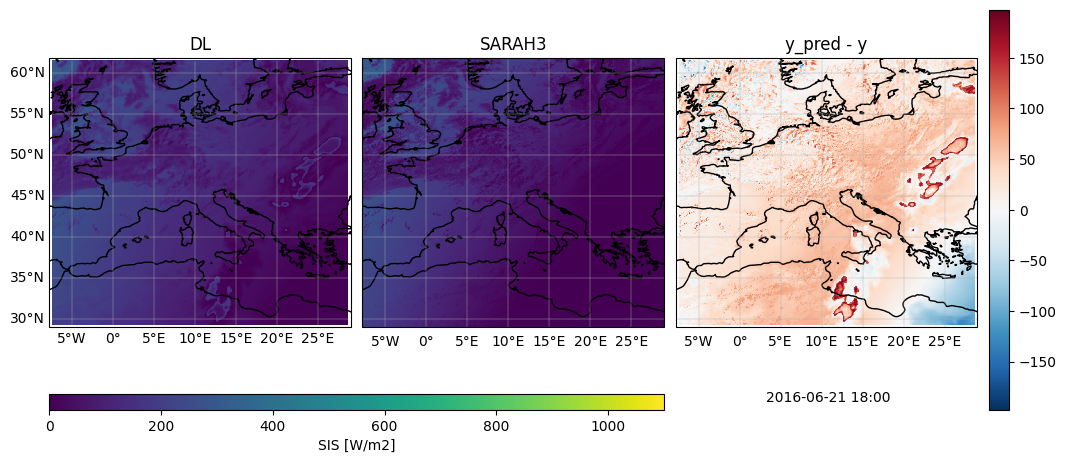

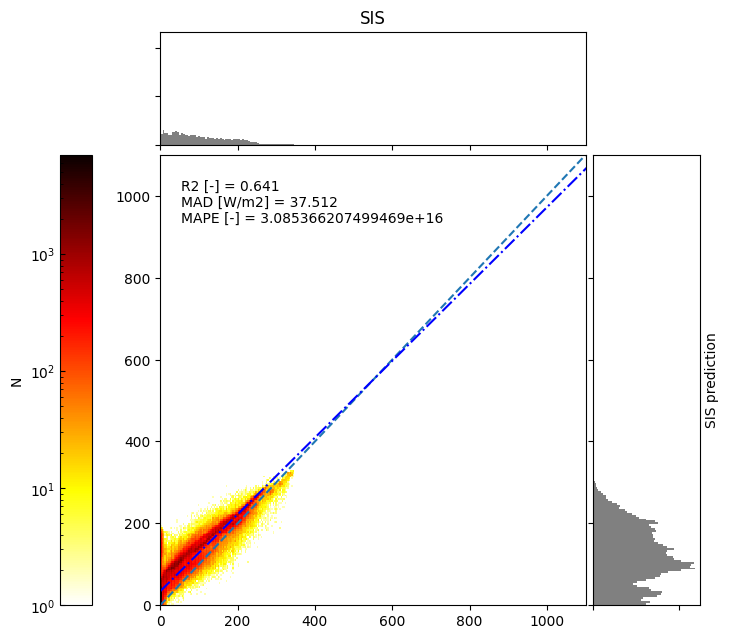

In [18]:
plot_comparison_image(output_image, dataset.sarah.isel(time=0).SIS)#, extent=[5, 40, 15,50])

fig = prediction_error_plot(y.flatten(), y_hat.flatten())
time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
fig.savefig(inference_fn + f'prediction_error_plot_{time_str}.png')